### Monte Carlo Tree Search 

#### Importing Necessary Packages:

In [1]:
import math
import random
import pandas as pd
import numpy as np
from numpy import random as rand
from binarytree import build
from itertools import chain
from binarytree import Node
from random import choice
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

#### Trial Run:

In [2]:
def create_tree(depth):
    """
    Generates a list of nodes given naming convention
    """
    l = []
    lst = ['S', 'L', 'R']
    dummy = ['L', 'R']
    while len(l)<2**depth:
        l = []
        for i in dummy:
            l.append(i+'L')
            l.append(i+'R') 
        lst.append(l)
        dummy = l.copy()
    return lst, l

#### Sample Tree (Depth$=4$)

In [3]:
lst, l = create_tree(4)
# Building the binary tree
binary_tree = build(list(chain.from_iterable(lst)))
print('Binary tree from list :\n',
      binary_tree)

Binary tree from list :
 
                                 _______________________________S_______________________________
                                /                                                               \
                _______________L______________                                    _______________R______________
               /                              \                                  /                              \
        ______LL______                   ______LR______                   ______RL______                   ______RR______
       /              \                 /              \                 /              \                 /              \
   __LLL_           __LLR_          __LRL_           __LRR_          __RLL_           __RLR_          __RRL_           __RRR_
  /      \         /      \        /      \         /      \        /      \         /      \        /      \         /      \
LLLL     LLLR    LLRL     LLRR   LRLL     LRLR    LRRL

#### Creating Node Class:

In [4]:
class Node:
    def __init__(self, node_id=None):
        self.left = None
        self.right = None
        self.node_id = node_id
        self.value = None

    def __repr__(self):
        return "node@" + str(self.node_id)

    def __str__(self):
        return "node@" + str(self.node_id)

    def is_terminal(self):
        if self.left is None and self.right is None:
            return True
        return False

    def find_children(self):
        if self.is_terminal():
            return {}
        return {self.left, self.right}

    def find_children_list(self):
        """This makes sure left, right order instead of an unsorted set"""
        if self.is_terminal():
            return []
        return [self.left, self.right]

    def find_random_child(self):
        if self.is_terminal():
            return None
        if choice([0, 1]) == 0:
            return self.left
        else:
            return self.right

    def reward(self):
        return self.value

#### Creating MCTS Class:

In [5]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1.0):
        self.Q = defaultdict(float)  # total reward of each node
        self.N = defaultdict(float)  # total visit count for each node
        self.children = dict()  # children of each node: key is explored node, value is set of children
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def run(self, node, num_rollout):
        "Run on iteration of select -> expand -> simulation(rollout) -> backup"
        path = self.select(node)
        leaf = path[-1]
        self.expand(leaf)
        reward = 0
        for i in range(num_rollout):
            reward += self.simulate(leaf)
        self.backup(path, reward)

    def select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def simulate(self, node):
        "Run a random simulation from node as starting point"
        while True:
            if node.is_terminal():
                return node.reward()
            node = node.find_random_child()

    def backup(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        # a node is fully expanded if and only if all children are explored
        is_all_children_expanded = all(n in self.children for n in self.children[node])
        if not is_all_children_expanded:
            raise ValueError("Can only select fom fully expanded node")

        log_N_parent = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_parent / self.N[n]
            )

        return max(self.children[node], key=uct)

#### Defining Functions:

In [6]:
def make_binary_tree(reward_list, depth=20):
    """
    Generates a binary tree of a given depth and reward values 
    """
    all_nodes = []
    for i in range(depth + 1):
        nodes_at_depth = []
        num_of_nodes = pow(2, i)
        for j in range(num_of_nodes):
            nodes_at_depth.append(Node(str(i) + "_" + str(j)))
        all_nodes.append(nodes_at_depth)

    leaf_nodes_dict = dict()
    for level, nodes in enumerate(all_nodes):
        for loc, n in enumerate(nodes):
            if level >= len(all_nodes) - 1:
                # we assign reward value to leaf nodes of the tree
                n.value = reward_list[loc]
                leaf_nodes_dict[n] = n.value
            else:
                left = all_nodes[level + 1][2 * loc]
                right = all_nodes[level + 1][2 * loc + 1]
                n.left = left
                n.right = right
    root = all_nodes[0][0]
    return root, leaf_nodes_dict

def mcts_playout(reward_list, depth, num_iter, num_rollout, exploration_weight):
    """
    Performs Monte Carlo Tree Search on the given binary tree to return Optimal value
    """
    root, leaf_nodes_dict = make_binary_tree(reward_list, depth=depth)
    leaf_nodes_dict_sorted = sorted(leaf_nodes_dict.items(), key=lambda x: x[1], reverse=True)
    mcts = MCTS(exploration_weight=exploration_weight)
    while True:
        # we run MCTS simulation for many times
        for _ in range(num_iter):
            mcts.run(root, num_rollout=num_rollout)
        # we choose the best greedy action based on simulation results
        root = mcts.choose(root)
        # we repeat until root is terminal
        if root.is_terminal():
            return root.value
        
def diff_letters(a,b):
    """
    Calculates the number of character differences between two strings of same length
    """
    return sum(a[i] != b[i] for i in range(len(a)))

#### Running MCTS:

$$B=200$$

$$d_{max}=20$$

$$\tau=\frac{d_{max}}{4}=5$$

$$x_{i}=B\cdot e^{\frac{-d_{i}}{\tau}}+\epsilon_{i}$$
where,
$$\epsilon_{i}\sim N(0,1)$$

In [7]:
reward_list = []
depth=20
num_iter = 50
num_rollout = 1
exploration_weight = np.arange(1, 211, 10)
num_experiments = 20
exp_res = defaultdict(list)
lst, l = create_tree(depth)

for c in l:
    value = 200*math.exp(-diff_letters(l[0],c)/5) + rand.normal(0,1)
    reward_list.append(value)

for e in exploration_weight:
    for i in range(num_experiments):
        found_max = mcts_playout(reward_list, depth=depth, num_iter=num_iter, num_rollout=num_rollout, exploration_weight=e)
        exp_res[e].append(found_max)
        
exp_res_df = pd.DataFrame(exp_res)
exp_res_df

,1,11,21,31,41,51,61,71,81,91,...,111,121,131,141,151,161,171,181,191,201
0,110.561822,163.523838,163.816592,163.523838,163.307636,199.410052,164.310745,199.410052,199.410052,163.478201,...,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052
1,109.873037,89.138470,163.478201,164.075046,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,...,199.410052,199.410052,199.410052,163.478201,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052
2,136.169794,164.896018,162.095490,162.476793,199.410052,132.866160,199.410052,164.896018,199.410052,199.410052,...,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052
3,73.975651,134.540057,134.461208,134.987217,199.410052,199.410052,163.791707,199.410052,199.410052,163.523838,...,199.410052,199.410052,163.478201,199.410052,199.410052,199.410052,163.478201,199.410052,199.410052,199.410052
4,89.786673,134.069187,199.410052,134.987217,164.075046,199.410052,199.410052,199.410052,199.410052,199.410052,...,199.410052,199.410052,199.410052,163.478201,199.410052,199.410052,199.410052,199.410052,163.523838,199.410052
5,108.335647,163.791707,164.338861,199.410052,163.523838,199.410052,199.410052,199.410052,199.410052,163.044635,...,199.410052,199.410052,199.410052,199.410052,163.523838,199.410052,199.410052,199.410052,199.410052,199.410052
6,90.223307,110.501292,133.522223,199.410052,163.478201,163.676640,199.410052,199.410052,199.410052,163.523838,...,199.410052,164.310745,199.410052,199.410052,199.410052,199.410052,163.523838,199.410052,199.410052,163.523838
7,61.016335,108.915167,163.791707,199.410052,199.410052,163.523838,199.410052,199.410052,199.410052,199.410052,...,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052
8,88.292057,163.676640,199.410052,199.410052,163.044635,199.410052,199.410052,199.410052,199.410052,199.410052,...,163.523838,199.410052,199.410052,199.410052,163.523838,199.410052,199.410052,199.410052,199.410052,199.410052
9,134.042661,107.453660,163.816592,163.523838,199.410052,199.410052,199.410052,199.410052,199.410052,199.410052,...,164.310745,199.410052,199.410052,199.410052,199.410052,199.410052,163.307636,199.410052,199.410052,199.410052


#### Plotting Extrapolation Weight Graph:

Text(0.5, 1.0, 'Monte Carlo Tree Search Results (Averaged over 20 runs)')

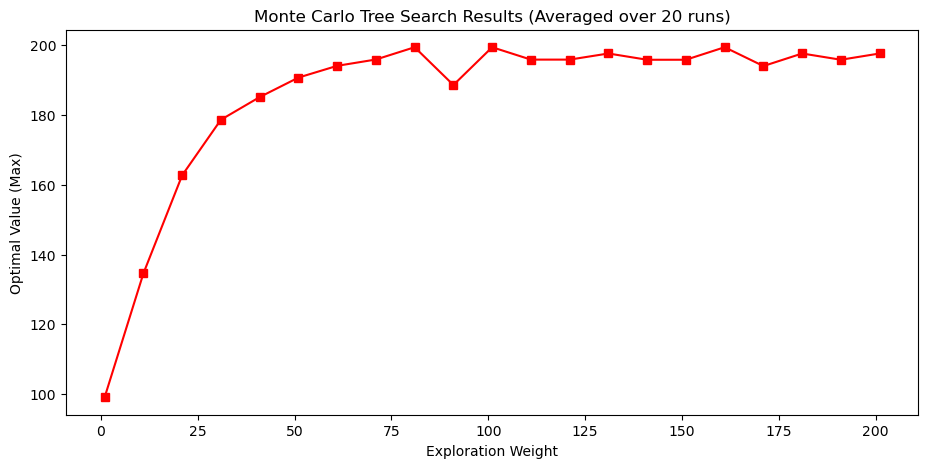

In [9]:
exp_res_df.mean(axis=0).plot(figsize=(11,5),marker='s',color='r', linestyle='solid')
plt.xlabel("Exploration Weight")
plt.ylabel("Optimal Value (Max)")
plt.title("Monte Carlo Tree Search Results (Averaged over 20 runs)")